In [2]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/Berkeley/PROJECT/Test')

Mounted at /content/drive


# **4 BIAS CORRECTION AND ML MODEL IMPROVEMENT**

The plan in to assess the imbalance in the dataset, correct it, run the the baseline on the new balanced dataset, compare the results with the original and finally run Random Forest, select the best parameter to get the best performance possible.

## 4.1 Assess Data imbalance

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('Telemetry_ready4ML.csv', parse_dates=['PreciseTimeStamp'])

# Step 1: Remove nodes that only experienced Sev1 but no Sev2
nodes_to_filter_out = df.groupby('NodeId').filter(
    lambda x: ('Sev1' in x['Severity'].values) and ('Sev2' not in x['Severity'].values)
)['NodeId'].unique()
df_filtered = df[~df['NodeId'].isin(nodes_to_filter_out)].copy()

def filter_unpreceded_sev1(group):
    group = group.sort_values(by='PreciseTimeStamp')
    rows_to_keep = []
    sev2_encountered = False
    for _, row in group.iterrows():
        if row['Severity'] == 'Sev2':
            rows_to_keep.append(row)
            sev2_encountered = True
        elif row['Severity'] == 'Sev1':
            if sev2_encountered:
                rows_to_keep.append(row)
        else:
            rows_to_keep.append(row)
    return pd.DataFrame(rows_to_keep) if rows_to_keep else pd.DataFrame()

df_filtered_by_sequence = df_filtered.groupby('NodeId').apply(filter_unpreceded_sev1).reset_index(drop=True)

# Step 4: Identify # of nodes with Sev1 from the previous filtered set
nodes_with_remaining_sev1 = df_filtered_by_sequence[df_filtered_by_sequence['Severity'] == 'Sev1']['NodeId'].unique()

# Pie chart data
num_nodes_with_sev2_before_sev1 = len(nodes_with_remaining_sev1)
total_nodes_final_dataset = df_filtered_by_sequence['NodeId'].nunique()
num_other_nodes = total_nodes_final_dataset - num_nodes_with_sev2_before_sev1

# Plotting the pie chart
labels = ['Sev2 before Sev1', 'Only Sev2 Nodes']
sizes = [num_nodes_with_sev2_before_sev1, num_other_nodes]
colors = ['#ff9999','#66b3ff']
explode = (0.1, 0)

plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, explode=explode)
plt.title('Proportion of Nodes: Sev2 before Sev1 vs. only Sev2 nodes')
plt.axis('equal')
plt.show()


This previous Pie chart answer the question "What percentage of nodes with Sev2 ever escalated to Sev1 ?" in this case each NodeId counts once. This is a node-level summary, not incident specific.



However, to train a machine learning model, we want to train a model to answer a different question:  "Given a specific Sev2 incident,  will this incident eventually results in a Sev1 ?"  The follwoing code shows the class imbalance:

In [4]:
# Re-import necessary packages
import pandas as pd

# Load the telemetry dataset
df = pd.read_csv('Telemetry_ready4ML.csv', parse_dates=['PreciseTimeStamp'])

# Split into Sev1 and Sev2 for analysis
sev1_df = df[df["Severity"] == "Sev1"]
sev2_df = df[df["Severity"] == "Sev2"].copy()

# Initialize new label
sev2_df["Sev1caused"] = 0

# For each Sev2, check if there's a Sev1 on the same NodeId that happens after it
for index, row in sev2_df.iterrows():
    node = row["NodeId"]
    timestamp = row["PreciseTimeStamp"]
    escalated = ((sev1_df["NodeId"] == node) & (sev1_df["PreciseTimeStamp"] > timestamp)).any()
    if escalated:
        sev2_df.at[index, "Sev1caused"] = 1

# Check class imbalance
imbalance_summary = sev2_df["Sev1caused"].value_counts().rename(index={0: "No Sev1 After", 1: "Sev1 Caused"})
imbalance_percentage = sev2_df["Sev1caused"].value_counts(normalize=True).rename(index={0: "No Sev1 After", 1: "Sev1 Caused"}) * 100
imbalance_df = pd.concat([imbalance_summary, imbalance_percentage.rename("Percentage")], axis=1)
print(imbalance_df)

               count  Percentage
Sev1caused                      
No Sev1 After   4035   67.452357
Sev1 Caused     1947   32.547643


No Sev1 After (Negative Class): 4035 incidents → 67.45%
Sev1 Caused (Positive Class): 1947 incidents → 32.55%
This is a moderate class imbalance. However if I want to improve the performance of the model I need to Balance the data set


## 4.2 Chart class distribution

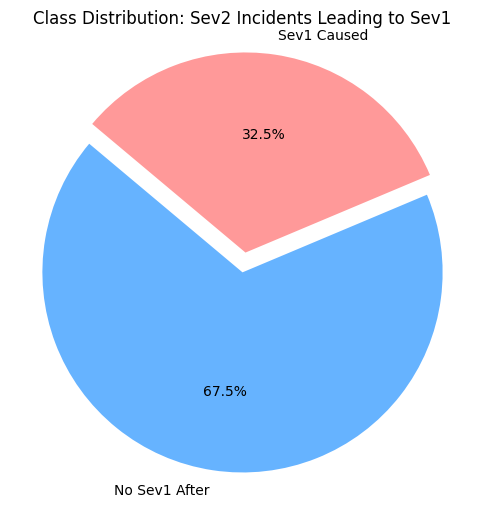

In [5]:
import matplotlib.pyplot as plt

# Recreate and show the pie chart
label_counts = sev2_df["Sev1caused"].value_counts().sort_index()
labels = ['No Sev1 After', 'Sev1 Caused']
sizes = [label_counts[0], label_counts[1]]
colors = ['#66b3ff', '#ff9999']
explode = (0, 0.1)

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
        startangle=140, explode=explode)
plt.title('Class Distribution: Sev2 Incidents Leading to Sev1')
plt.axis('equal')
plt.show()


## 4.3 Undersampling to decrease the bias

In [8]:
from sklearn.utils import resample

# Separate the majority and minority classes
majority_class = sev2_df[sev2_df["Sev1caused"] == 0]
minority_class = sev2_df[sev2_df["Sev1caused"] == 1]

# Downsample the majority class to match the size of the minority class
majority_downsampled = resample(
    majority_class,
    replace=False,                  # without replacement
    n_samples=len(minority_class), # match minority class
    random_state=42
)

# Combine the downsampled majority class with the minority class
undersampled_df = pd.concat([majority_downsampled, minority_class])

# Shuffle the dataset
undersampled_df = undersampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Confirm new class distribution
undersampled_summary = undersampled_df["Sev1caused"].value_counts().rename(index={0: "No Sev1 After", 1: "Sev1 Caused"})
undersampled_percentage = undersampled_df["Sev1caused"].value_counts(normalize=True).rename(index={0: "No Sev1 After", 1: "Sev1 Caused"}) * 100
undersampled_dist = pd.concat([undersampled_summary, undersampled_percentage.rename("Percentage")], axis=1)
print(undersampled_dist)



               count  Percentage
Sev1caused                      
Sev1 Caused     1947        50.0
No Sev1 After   1947        50.0


#4.4 Comparing new with original Baseline

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import pandas as pd

# Use the previously balanced dataset (undersampled_df)
# One-hot encode categorical features
categorical_cols = ["RCALevel2", "Scenario", "ServiceName"]
X = pd.get_dummies(undersampled_df[categorical_cols])
y = undersampled_df["Sev1caused"]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Classification report
report = classification_report(y_test, y_pred, output_dict=False)
print(report)


              precision    recall  f1-score   support

           0       0.66      0.66      0.66       593
           1       0.65      0.66      0.66       576

    accuracy                           0.66      1169
   macro avg       0.66      0.66      0.66      1169
weighted avg       0.66      0.66      0.66      1169



comparing with the previous Imbalanced dataset ..

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Prepare the original imbalanced dataset
categorical_cols = ["RCALevel2", "Scenario", "ServiceName"]
X_full = pd.get_dummies(sev2_df[categorical_cols])
y_full = sev2_df["Sev1caused"]

# Split into train and test sets
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y_full, test_size=0.3, random_state=42)

# Train the logistic regression model
model_full = LogisticRegression(max_iter=1000)
model_full.fit(X_train_full, y_train_full)

# Predictions
y_pred_full = model_full.predict(X_test_full)
y_prob_full = model_full.predict_proba(X_test_full)[:, 1]

# Generate the classification report
report_full = classification_report(y_test_full, y_pred_full, output_dict=False)
print(report_full)


              precision    recall  f1-score   support

           0       0.73      0.97      0.83      1183
           1       0.84      0.30      0.44       612

    accuracy                           0.74      1795
   macro avg       0.78      0.64      0.64      1795
weighted avg       0.77      0.74      0.70      1795



the perfromance with the undersampled dataset is better, since the balance between precision and recall is more equilibred, this means **Lower accuracy but better detecting Sev1 escalations**

<Figure size 600x600 with 0 Axes>

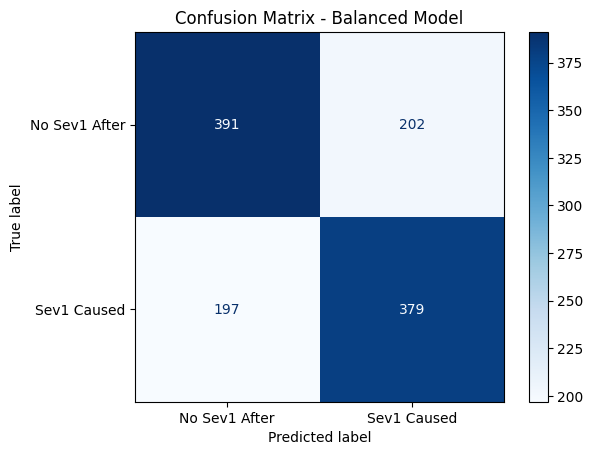

<Figure size 600x600 with 0 Axes>

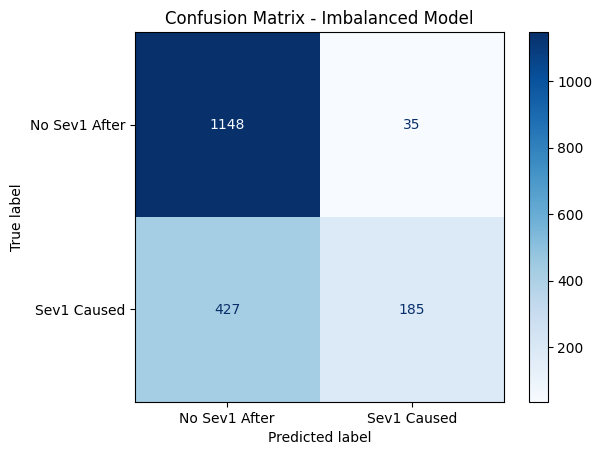

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix for the balanced model
cm_balanced = confusion_matrix(y_test, y_pred)
disp_balanced = ConfusionMatrixDisplay(confusion_matrix=cm_balanced, display_labels=["No Sev1 After", "Sev1 Caused"])

# Plot for balanced model
plt.figure(figsize=(6, 6))
disp_balanced.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - Balanced Model")
plt.show()

# Generate confusion matrix for the imbalanced model
cm_imbalanced = confusion_matrix(y_test_full, y_pred_full)
disp_imbalanced = ConfusionMatrixDisplay(confusion_matrix=cm_imbalanced, display_labels=["No Sev1 After", "Sev1 Caused"])

# Plot for imbalanced model
plt.figure(figsize=(6, 6))
disp_imbalanced.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - Imbalanced Model")
plt.show()


is clear with balanced dataset the model is better predicting Sev1, now is able to predict 379 cases, before was able to predict only 185


the last step is to use a Random Forest to see if we can increase the success of Sev1 predictions


## 4.5 Random Forest Classifier

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Train a Random Forest classifier on the balanced dataset
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test)
report_rf = classification_report(y_test, y_pred_rf, output_dict=False)

# Show classification report
print(report_rf)



              precision    recall  f1-score   support

           0       0.65      0.70      0.68       593
           1       0.67      0.62      0.64       576

    accuracy                           0.66      1169
   macro avg       0.66      0.66      0.66      1169
weighted avg       0.66      0.66      0.66      1169



<Figure size 600x600 with 0 Axes>

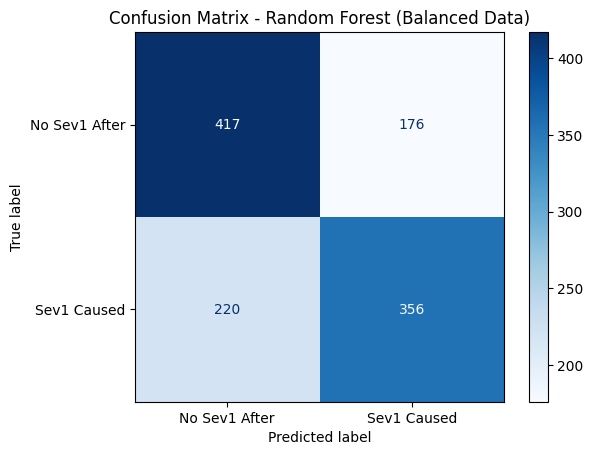

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix for Random Forest model
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["No Sev1 After", "Sev1 Caused"])

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
disp_rf.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - Random Forest (Balanced Data)")
plt.show()


Small improvement in recall for class 0, small drop for class 1. Not a big improvement, the performance is similar to logistic regression.

## 4.6 Parameter Tuning in Random Forest to find a better performance..

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# Create the base model
rf = RandomForestClassifier(random_state=42)

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=3, n_jobs=-1, scoring='f1', verbose=1)

# Run grid search on the balanced dataset
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_

# Best model
best_rf_model = grid_search.best_estimator_

# Evaluate best model
y_pred_best_rf = best_rf_model.predict(X_test)
best_rf_report = classification_report(y_test, y_pred_best_rf, output_dict=False)

print(best_params)
print(best_rf_report)


Fitting 3 folds for each of 48 candidates, totalling 144 fits
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.65      0.70      0.68       593
           1       0.67      0.62      0.64       576

    accuracy                           0.66      1169
   macro avg       0.66      0.66      0.66      1169
weighted avg       0.66      0.66      0.66      1169



is the same performance than before


# **CONCLUSION**


## Overall Performance:

Accurancy around 66%, F1-score both classes around 66%, and Precision between 65 - 70% makes this model very well balanced, this means the model is not predicting one class over the other class. In real life, this means the model will not raise unnecessary false Sev1 alarms, and is not going to miss a real Sev1 often.

## Business Interpretation
The Random Forest model trained on the balanced data correctly predicts escalations from Sev2 to Sev1 about two-thirds (66%) of the time, with equal sensitivity to both escalation and non-escalation paths. Further improvements could be implemented using more granular features or historical patterns. However, with the current dataset and time restriction for this project, is not possible to continue exploring more options.

Finally, 66% success predicting escalations from Sev2 to Sev1 is a big win for the current situation, where we rely on human expertice which does not have the time to review such a large amount of nodes on Sev2s